<a href="https://colab.research.google.com/github/geyzon-assis/aluracare/blob/master/AluraCare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predição de Casos de Câncer
o câncer é uma das doenças que mais mata no mundo, e o objetivo deste projeto é prever a incidência de casos malignos dado um conjunto de dados de exames fornecidos previamente, onde constam resultado de exames e o diagnóstico, podendo ser considerado maligno ou benigno

*Base de dados contêm dados fictícios apenas para estudos de caso*

#importando bibliotecas e dataset
Faremos a utilização da bibliotecas padrão em ciencia de dados como pandas e numpy, bem como bibliotecas de visualização de dados. No decorrer do desenvolmente do projeto, serão também importadas outras bibliotecas mais específicas.

In [95]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



Essa será nossa base de dados para o estudo

In [96]:
uri = "https://raw.githubusercontent.com/alura-cursos/reducao-dimensionalidade/master/data-set/exames.csv"
dados = pd.read_csv(uri)
dados

,id,diagnostico,exame_1,exame_2,exame_3,exame_4,exame_5,exame_6,exame_7,exame_8,exame_9,exame_10,exame_11,exame_12,exame_13,exame_14,exame_15,exame_16,exame_17,exame_18,exame_19,exame_20,exame_21,exame_22,exame_23,exame_24,exame_25,exame_26,exame_27,exame_28,exame_29,exame_30,exame_31,exame_32,exame_33
0,842302,M,17.99,10.38,122.80,103.78,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.786,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,103.78,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.786,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,103.78,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.786,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,103.78,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.786,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,103.78,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.786,0.1625,0.2364,0.07678,0.854454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,103.78,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.786,0.2216,0.2060,0.07115,0.158771
565,926682,M,20.13,28.25,131.20,103.78,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.786,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,103.78,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.786,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,103.78,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.786,0.2650,0.4087,0.12400,NaN


Podemos notar uma base de dados multidimensional constando 35 dimensões, sendo 33 exames no nosso experimento, bem como a coluna diagnóstico, que será nosso objetivo de predição e a coluna id que não terá serventia para o propósito do experimento

#Análise exploratória de dados

Iremos agora verificar a quantidade de cada tipo de diagnóstico em nossa base de dados

In [97]:
dados.diagnostico.value_counts() # B - Benigno, M - Maligno

B    357
M    212
Name: diagnostico, dtype: int64

Agora vamos fazer uma contagem de possiveis dados nulos em nossa base de dados

In [98]:
dados.isnull().sum()

id               0
diagnostico      0
exame_1          0
exame_2          0
exame_3          0
exame_4          0
exame_5          0
exame_6          0
exame_7          0
exame_8          0
exame_9          0
exame_10         0
exame_11         0
exame_12         0
exame_13         0
exame_14         0
exame_15         0
exame_16         0
exame_17         0
exame_18         0
exame_19         0
exame_20         0
exame_21         0
exame_22         0
exame_23         0
exame_24         0
exame_25         0
exame_26         0
exame_27         0
exame_28         0
exame_29         0
exame_30         0
exame_31         0
exame_32         0
exame_33       419
dtype: int64

Podemos notar que temos uma coluna com 419 dados faltantes, representando cerca de 75% dos registro totais.
Por se tratar de uma quantidade muito alta de registros faltantes, se torno inviável utilizarmos outras estratégias para resolvermos, como preenchimento com a média por exemplo, e por isso iremos excluir essa coluna

In [99]:
dados.drop(columns=['exame_33'], inplace=True)

#Pré-processamento
Utilizaremos algumas vizualizações para ajudar na seleção de parâmetros para nosso modelo de classificação. Também faremos o uso de alguns artifícios para buscar reduzir a alta dimensionalidade dos nossos dados

Aproveitaremos separaremos nossos dados entre x e y, onde x será nossos dados preditores, e y será nosso target, ou seja, nosso objetivo de predição.
Aproveitaremos para excluir a coluna id do nosso dataset



In [100]:
x = dados.drop(columns=['id','diagnostico'])
y = dados['diagnostico']

Para ajudar na construção das visualizações, será necessário colocarmos os resultados dos exames dentro de uma escala mais próxima entre si. Para isso utilizaremos o StandardScaler no pacote do Sklearn

In [101]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x)
exames_2 = scaler.transform(x)
exames_2 = pd.DataFrame(exames_2, columns=exames.keys())

Vamos criar uma visualização do Seaborn do tipo violino, para entendermos melhor os resuldados dos exames e sua distribuição

In [102]:
#criamos uma função que recebe o dataframe, o inicio e o fim dos itens que queremos plotar no gráfico
def grafico_violino(dados,inicio,fim):

  import seaborn as sns
  import matplotlib.pyplot as plt

  dados_plot = pd.concat([y,dados.iloc[:,inicio:fim]],axis=1) #Estamos criando um subconjunto dos dados para termos o controle
                                                              # na hora da visualização do grafico
  dados_plot = pd.melt(dados_plot,id_vars='diagnostico',var_name='exames',value_name="valores")
  
  plt.figure(figsize=(20,10))
  plt.xticks(rotation =90)
  sns.violinplot(x = 'exames', y = 'valores',hue = 'diagnostico',
               split = True, data = dados_plot)

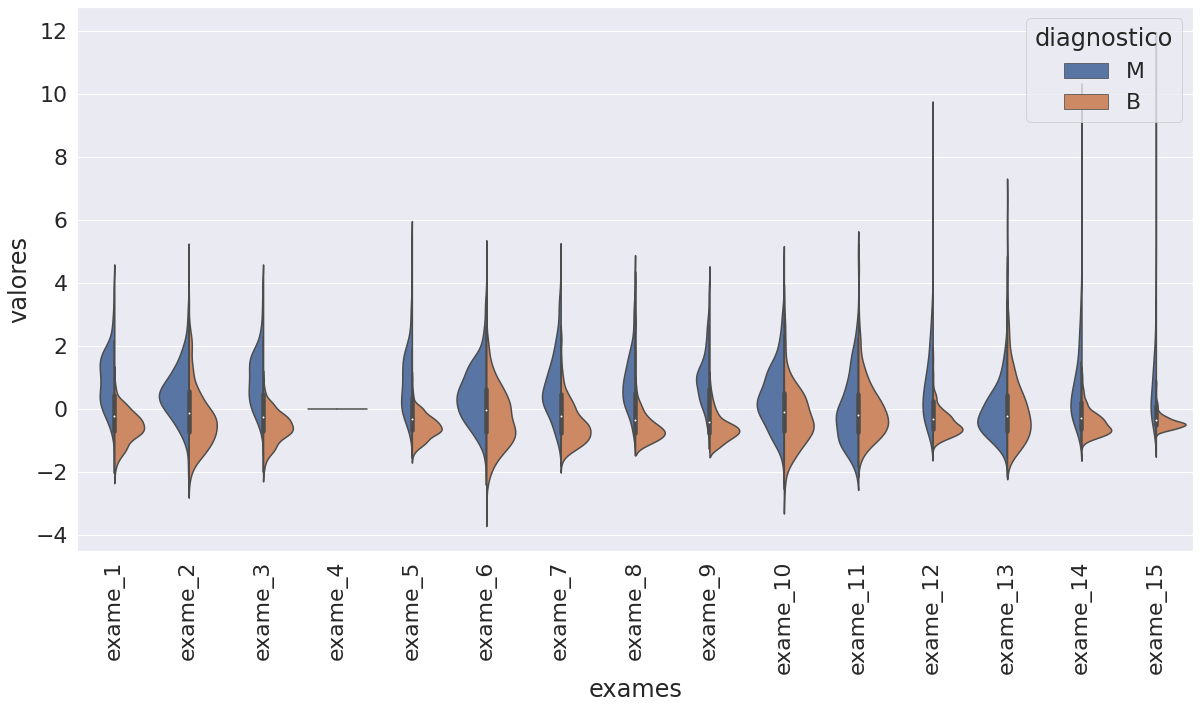

In [103]:
grafico_violino(exames_2,0,15)

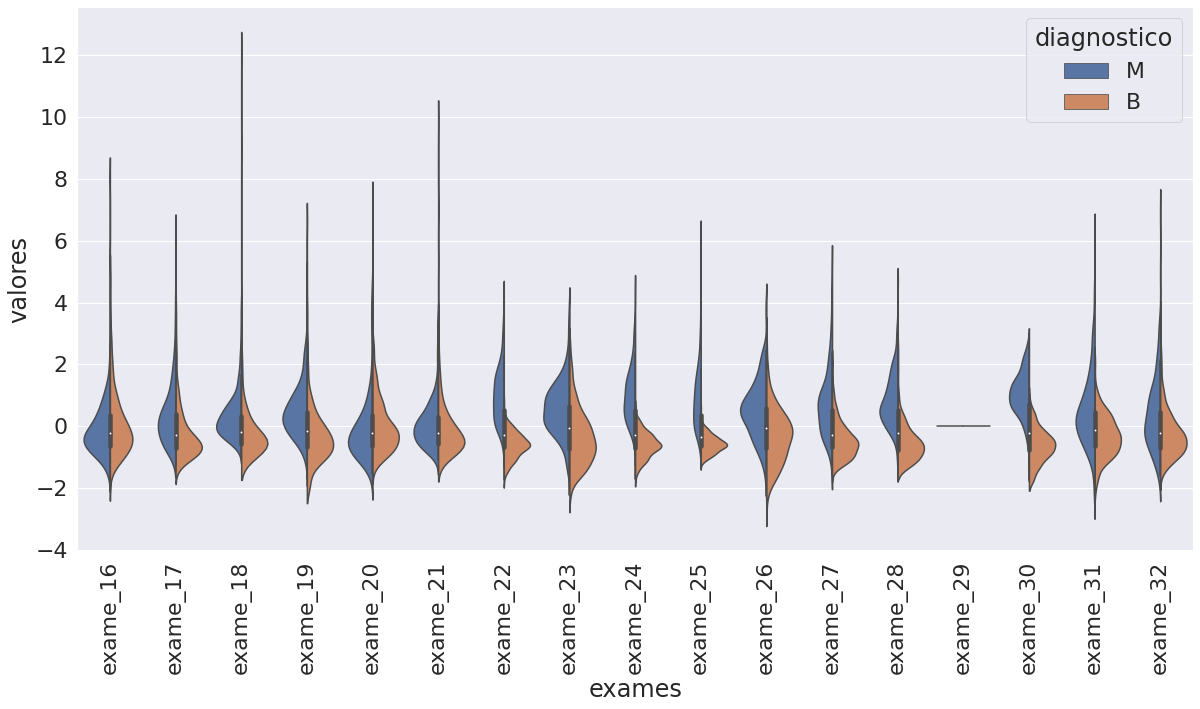

In [104]:
grafico_violino(exames_2,15,32)

As colunas exame_4 e exame_29 possuem valores constantes e não contribuem positivamente no nosso modelo. Por esse motivo vamos retira-las do nosso conjunto de dados 

In [105]:
exames_3 = exames_2.drop(columns=['exame_4','exame_29'])

#Modelagem - Machine Learning

Vamos criar um BASELINE para termos uma ideia base de quanto seria a taxa de acerto considerada aceitável. Esse baseline consiste em atribuir a classe que mais aparece a todos as resposta do modelo. Importante notar que não existe inteligencia aqui, ele está apenas 'chutando' todas as repostas iguais.

In [106]:
  from sklearn.dummy import DummyClassifier
  SEED = 1234
  np.random.seed(SEED)

  train_x,test_x,train_y,test_y = train_test_split(x,y,test_size=0.30,
                                                 stratify=y)
  dummy_mostfrequent = DummyClassifier(strategy='most_frequent')
  dummy_mostfrequent.fit(train_x,train_y)
  #predict = dummy_mostfrequent.predict(test_x)
  #accuracy = accuracy_score (test_y,predict) * 100
  accuracy = dummy_mostfrequent.score(test_x,test_y)
  print("Treinaremos com {} elementos e testaremos com {} elementos".format(len(train_x), len(test_x)))
  print('A acuracia do dummy mostfrequent foi {:.2f}%'.format(accuracy*100))

Treinaremos com 398 elementos e testaremos com 171 elementos
A acuracia do dummy mostfrequent foi 62.57%


Estamos criando uma função com o objetivo de facilitar no momento de rodar o modelo de RandonForest

In [107]:
arvores = [1,5,10,15,20,30]

def classificador(dados_x,arvores = arvores):
  from sklearn.model_selection import train_test_split
  from sklearn.ensemble import RandomForestClassifier

  SEED = 1234
  np.random.seed(SEED)
  train_x,test_x,train_y,test_y = train_test_split(dados_x,y,test_size=0.30,
                                                 stratify=y)
  for i in arvores:
    model = RandomForestClassifier(n_estimators=i)
    model.fit(train_x,train_y)
    print("Resultado do RandomForest foi {:.2f}% com {} estimadores".format((model.score(test_x,test_y)*100),i))

Vamos estudar as correlações entre as variáveis, e como são todas variáveis numericas, podemos usar o corr(). Como fica muito complexo analizar olhando apenas os numeros das correlações, vamos usar um heatmap do seaborn

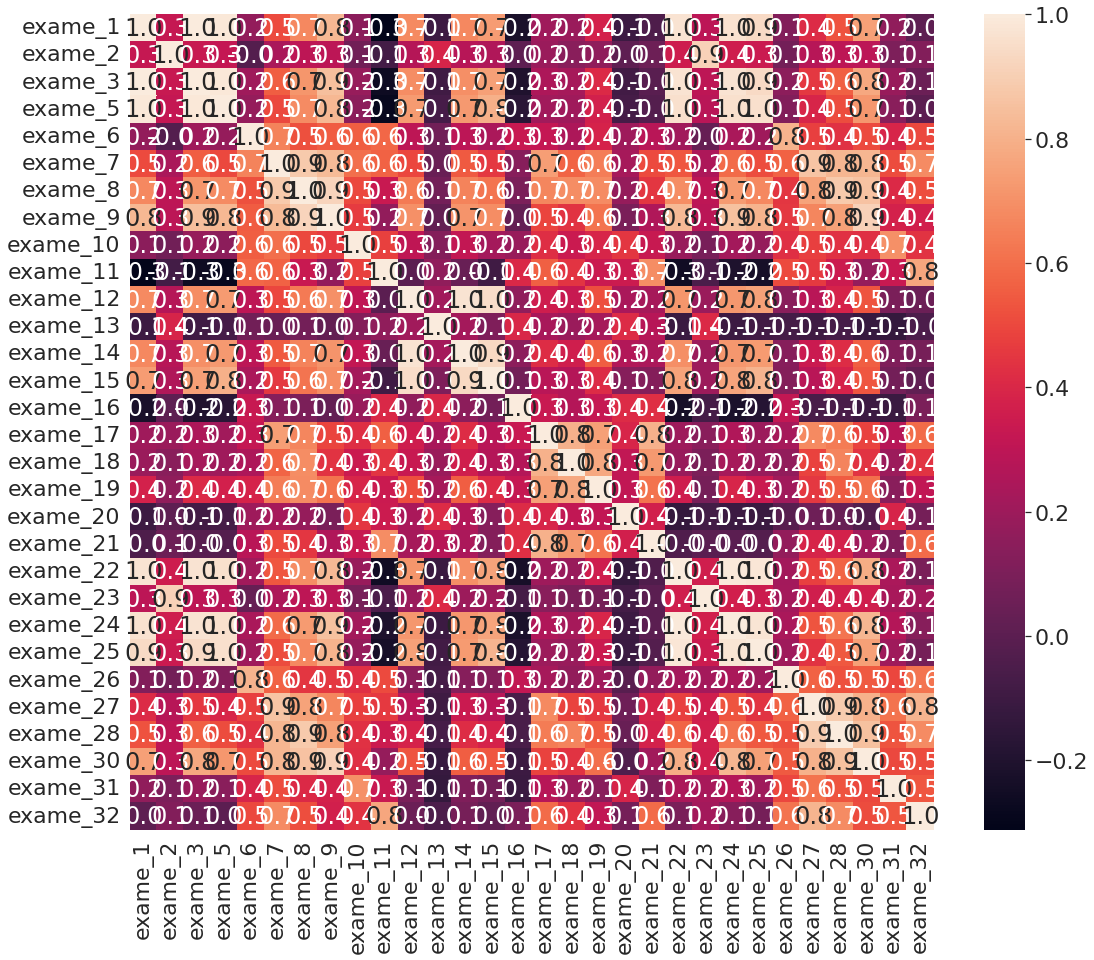

In [108]:
plt.figure(figsize=(18,15))
sns.heatmap(exames_3.corr(),annot=True, fmt = '.1f')

Agora iremos localizar quais são as variáveis de maior correlação entre si e elimina-las do nosso modelo a fim de reduzirmos a dimensionalidade dos nossos dados

In [109]:
matriz_correlacao = exames_3.corr()
matriz_alta_correlacao = matriz_correlacao[matriz_correlacao>0.99]
matriz_alta_correlacao.sum()
# A ideia aqui é descobrir as variáveis mais altamente correlacionadas e elimina-las
# do modelo para diminuirmos o numero de dimensões dos nosso dados


exame_1     1.997855
exame_2     1.000000
exame_3     1.997855
exame_5     1.000000
exame_6     1.000000
exame_7     1.000000
exame_8     1.000000
exame_9     1.000000
exame_10    1.000000
exame_11    1.000000
exame_12    1.000000
exame_13    1.000000
exame_14    1.000000
exame_15    1.000000
exame_16    1.000000
exame_17    1.000000
exame_18    1.000000
exame_19    1.000000
exame_20    1.000000
exame_21    1.000000
exame_22    1.993708
exame_23    1.000000
exame_24    1.993708
exame_25    1.000000
exame_26    1.000000
exame_27    1.000000
exame_28    1.000000
exame_30    1.000000
exame_31    1.000000
exame_32    1.000000
dtype: float64

In [110]:
variaveis_corr = matriz_alta_correlacao.sum()[matriz_alta_correlacao.sum()>1]
variaveis_corr

exame_1     1.997855
exame_3     1.997855
exame_22    1.993708
exame_24    1.993708
dtype: float64

Essas variaveis são altamentes correlacionadas, mas precisamos olhar no dataframe do corr() para entendermos qual está correlacionada com qual. Nesse caso, a correlação está entre a exame_1 com a exame_3 e na sequencia, exame_22 com exame_24.
vamos dessa forma então excluir uma coluna de cada correlação e testar nosso modelo

In [111]:

exames_4 = exames_3.drop(columns=["exame_3","exame_24"])
classificador(exames_4)

Resultado do RandomForest foi 91.23% com 1 estimadores
Resultado do RandomForest foi 95.32% com 5 estimadores
Resultado do RandomForest foi 97.66% com 10 estimadores
Resultado do RandomForest foi 96.49% com 15 estimadores
Resultado do RandomForest foi 95.91% com 20 estimadores
Resultado do RandomForest foi 96.49% com 30 estimadores


Vamos utilizar uma função do sklearn que será capaz de pegar nossos dados e fazer uma Score deles, selecionando apenas o que ele considera melhor para o modelo, fazendo os calculo utilizando o chi2 de Pearson

In [113]:
from sklearn.feature_selection import SelectKBest,chi2

selecionar_kmelhores = SelectKBest(score_func=chi2,k=14)
#passo o numero de features que pretendo receber
selecionar_kmelhores

SelectKBest(k=14, score_func=<function chi2 at 0x7fab38869170>)

Agora precisamos treinar o SelectKBest com nosso dados, mas como o chi2 não aceita valores negativos, precisamos utilizar os dados antes da padronização e remover as colunas que já tinhas retirado

In [139]:

dados_k = x.drop(columns=['exame_4','exame_29','exame_3','exame_24'])
SEED = 123
np.random.seed(SEED)
train_x,test_x,train_y,test_y = train_test_split(dados_k,y,test_size=0.30,
                                                 stratify=y)

selecionar_kmelhores.fit(train_x,train_y)
treino_kbest = selecionar_kmelhores.transform(train_x)
teste_kbest  = selecionar_kmelhores.transform(test_x)



model = RandomForestClassifier(n_estimators=10)
model.fit(treino_kbest,train_y)
print("Resultado do RandomForest foi {:.2f}%".format(model.score(teste_kbest,test_y)*100))


Resultado do RandomForest foi 96.49%


Vamos agora criar a Matriz de Confusão que serve para avaliarmos nossas prediçoes em relação a cada classe, a fim de indentificarmos se nosso modelo está superestimando alguma classe. Aqui poderemos interpretar a quantidade de falsos positivos, verdadeiros positivos, falsos negativos e verdadeiros negativos

In [140]:

from sklearn.metrics import confusion_matrix
matriz_confusao = confusion_matrix(test_y, model.predict(teste_kbest))
matriz_confusao

array([[104,   3],
       [  3,  61]])

Interpretação consiste em que nos dados reais, temos 107 casos negativos e 64 casos positivos,e que nosso algoritmos conseguiu indentificar 104 dos negativos, errando apenas 3 diagnóstivos e acertou 61 casos positivos para cancer, errando também 3 diagnósitos.

[Text(56.5, 0.5, 'Real'), Text(0.5, 38.5, 'Predição')]

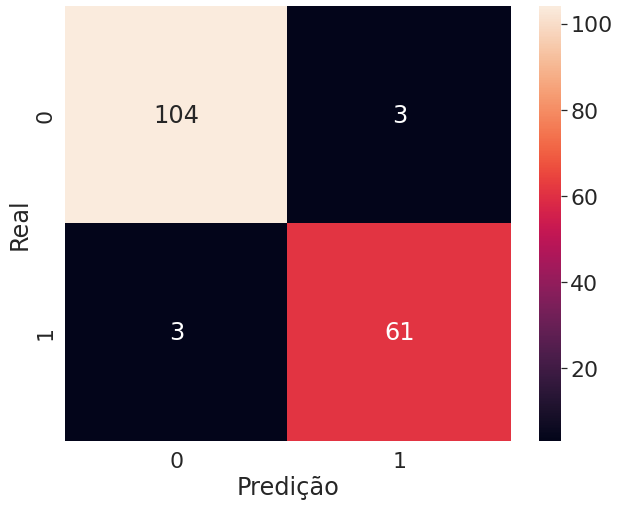

In [135]:
plt.figure(figsize = (10, 8))
sns.set(font_scale = 2)
sns.heatmap(matriz_confusao, annot = True, fmt = "d").set(xlabel = "Predição", ylabel = "Real")

Aqui utilizaremos um selecionador de features chamado RFE (Recursive feature elimination), que a partir de um modelo, seleciona as melhores features utilizando recursidade, buscando um conjunto de features cada vez menor.

Resultado do RandomForest foi 98.25%


[Text(56.5, 0.5, 'Real'), Text(0.5, 38.5, 'Predição')]

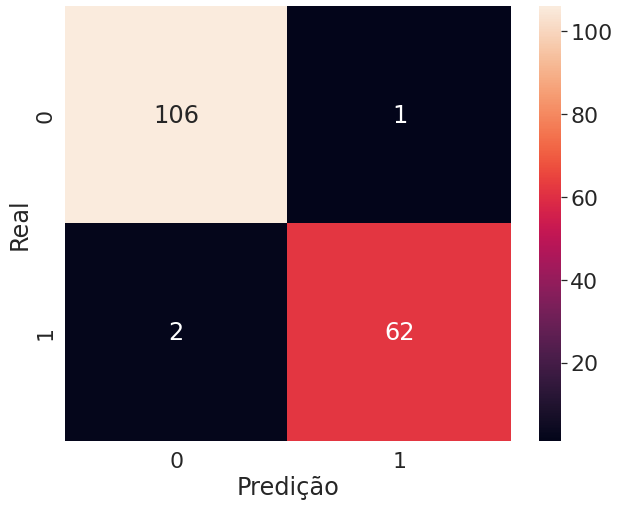

In [118]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


SEED = 1234
np.random.seed(SEED)
train_x,test_x,train_y,test_y = train_test_split(exames_4,y,test_size=0.30,
                                                 stratify=y)
model_rfe = RandomForestClassifier(n_estimators=100) #Instanciamos o modelo que será utilizado no RFE

#criamos o rfe setando o modelo, o numero de features pretendida e quantos passos
selecionador_rfe = RFE(estimator = model_rfe , n_features_to_select = 10, step = 1)
selecionador_rfe.fit(train_x,train_y) #Treinamos o selecionador com os dados de treino

train_rfe = selecionador_rfe.transform(train_x) #Geramos os novos dados de treino X usando o selecionador de features
test_rfe = selecionador_rfe.transform(test_x)# E os dados de teste X

model_rfe.fit(train_rfe,train_y) #treinamos o modelo instanciando anteriormente com os novos dados gerados pelo rfe

print("Resultado do RandomForest foi {:.2f}%".format(model_rfe.score(test_rfe,test_y)*100))

# GERANDO A MATRIZ DE CONFUSÃO
matriz_confusao = confusion_matrix(test_y, model_rfe.predict(test_rfe))
plt.figure(figsize = (10, 8))
sns.set(font_scale = 2)
sns.heatmap(matriz_confusao, annot = True, fmt = "d").set(xlabel = "Predição", ylabel = "Real")

Vamos utilizar agora o RFECV, que segue o mesmo principio do RFE buscando as melhores features e em menor quantidade possivel utilizando a recursividade, mas agora com Cross-Validation. É como se o algoritmo dividisse a base de dados em subconjuntos e aplicasse o RFE em cada um fazendo uma comparação entre eles

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  "X does not have valid feature names, but"


Resultado do RandomForest foi 98.25%


[Text(56.5, 0.5, 'Real'), Text(0.5, 38.5, 'Predição')]

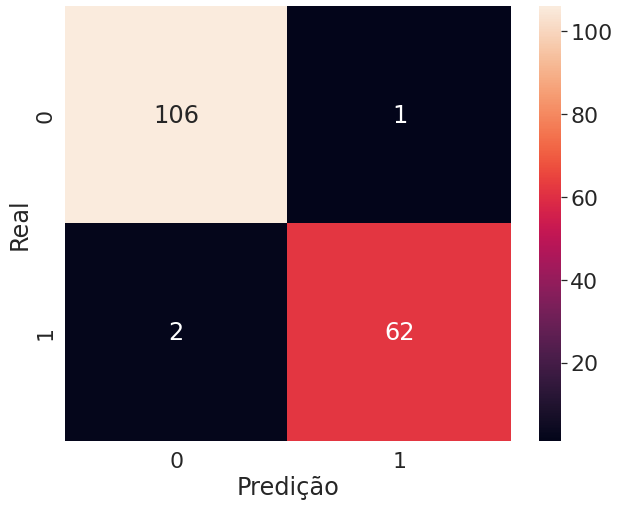

In [119]:
from sklearn.feature_selection import RFECV

#criamos o RFECV setando o modelo, o numero de features pretendida e quantos passos
selecionador_rfecv = RFECV(estimator = model_rfe , cv = 5,scoring = "accuracy" ,step = 1)
#o cv é o numero de splits que o algoritmo fará na base de dados
selecionador_rfecv.fit(train_x,train_y) #Treinamos o selecionador com os dados de treino

train_rfecv = selecionador_rfecv.transform(train_x) #Geramos os novos dados de treino X usando o selecionador de features
test_rfecv = selecionador_rfecv.transform(test_x)# E os dados de teste X

model_rfe.fit(train_rfecv,train_y) #treinamos o modelo instanciando anteriormente com os novos dados gerados pelo rfe

print("Resultado do RandomForest foi {:.2f}%".format(model_rfe.score(test_rfecv,test_y)*100))

# GERANDO A MATRIZ DE CONFUSÃO
matriz_confusao = confusion_matrix(test_y, model_rfe.predict(test_rfecv))
plt.figure(figsize = (10, 8))
sns.set(font_scale = 2)
sns.heatmap(matriz_confusao, annot = True, fmt = "d").set(xlabel = "Predição", ylabel = "Real")

In [120]:
print(selecionador_rfecv.n_features_) #Mostra quantas features o selector escolheu
print(selecionador_rfecv.support_) #Esse retorna um array com True onde a coluna foi selecionada
#entao podemos descobrir quais features ele utilizou
print(test_x.columns[selecionador_rfecv.support_])
# Score acumulativo para cada feature
print(selecionador_rfecv.grid_scores_)

14
[ True  True  True False False  True  True False False False False  True
  True False False False False False False  True  True  True  True  True
  True  True False False]
Index(['exame_1', 'exame_2', 'exame_5', 'exame_8', 'exame_9', 'exame_14',
       'exame_15', 'exame_22', 'exame_23', 'exame_25', 'exame_26', 'exame_27',
       'exame_28', 'exame_30'],
      dtype='object')
[[0.8625     0.9125     0.825      0.82278481 0.91139241]
 [0.975      0.9375     0.9125     0.84810127 0.91139241]
 [0.975      0.9625     0.9125     0.89873418 0.94936709]
 [0.9875     0.9625     0.925      0.91139241 0.92405063]
 [0.9875     0.95       0.925      0.88607595 0.93670886]
 [0.975      0.95       0.95       0.88607595 0.96202532]
 [0.975      0.95       0.95       0.87341772 0.92405063]
 [0.975      0.975      0.95       0.89873418 0.94936709]
 [0.9875     0.975      0.95       0.91139241 0.92405063]
 [0.9875     0.95       0.95       0.92405063 0.92405063]
 [0.9875     0.975      0.95       0.9

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


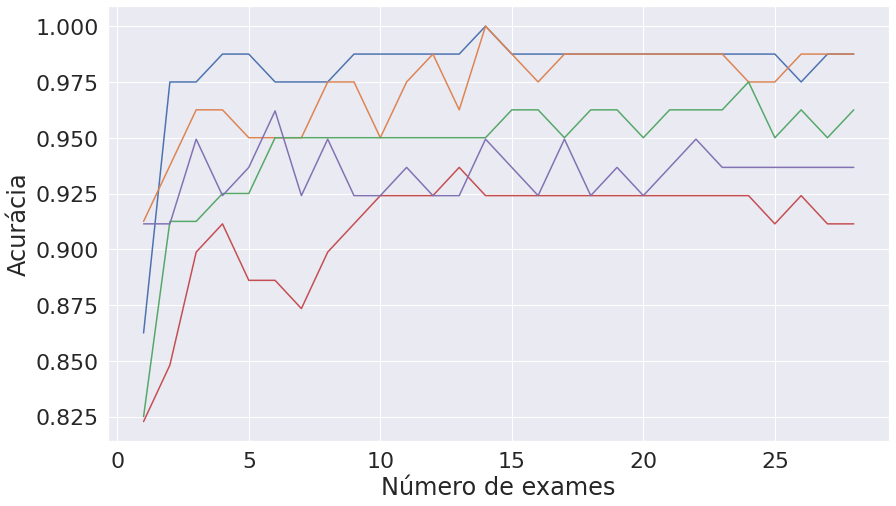

In [121]:
# Vamos plotar um grafico pra melhorar o entendimento
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
plt.xlabel("Número de exames")
plt.ylabel("Acurácia")

plt.plot(range(1, len(selecionador_rfecv.grid_scores_) + 1), selecionador_rfecv.grid_scores_)
plt.show()

Uma das técnicas que podemos utilizar para manter o máximo de informações possível em dimensionalidades reduzidas é o PCA. O PCA opera uma transformação matemática sobre os dados, na qual as primeiras dimensões serão as variáveis que manterão o maior volume possível de informação.

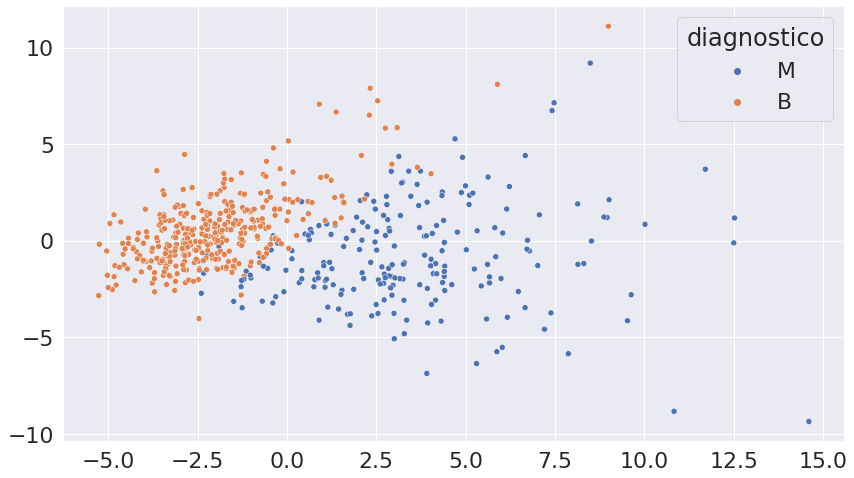

In [122]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
valores_exames_pca = pca.fit_transform(exames_4)
plt.figure(figsize=(14, 8))
sns.scatterplot(x = valores_exames_pca[:,0], y = valores_exames_pca[:,1], hue = diagnostico)

Ainda existe uma técnica que se comporta melhor quando queremos gerar visualizações, chamada t-SNE, que também está presente no SKlearn. De maneira resumida, a t-SNE tenta manter as distâncias entre os pontos.
Por exemplo, se calcularmos a distância entre o ponto 0 e o ponto 1, teremos um valor em 28 dimensões, que é a quantidade de features do nosso conjunto. O t-SNE tenta manter a proporção dessas distâncias na redução para dimensões menores, permitindo que tenhamos uma noção de quão distante um ponto está do outro.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


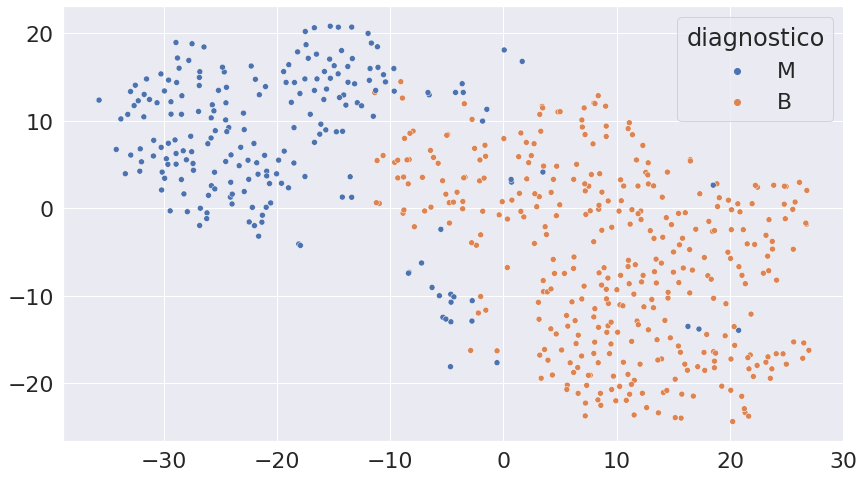

In [123]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2)
valores_exames_tsne = tsne.fit_transform(exames_4)

plt.figure(figsize=(14, 8))
sns.scatterplot(x = valores_exames_tsne[:,0], y = valores_exames_tsne[:,1], hue = diagnostico)

temos uma visualização que separa muito bem os dados no espaço, tornando mais claro quais pontos estão próximos de um tipo de câncer maligno ou benigno. Assim, é bem mais simples determinar uma fronteira entre tais classificações.

Essas técnicas que realizam uma transformação matemática nos dados antes de processá-los, reduzindo suas dimensões, são chamadas justamente de "redução de dimensionalidade". A diferença entre a redução de dimensionalidade e a seleção de features é que a segunda funciona como um funil que filtra as principais características de uma base de dados original.

